In [1]:
import os
import pandas as pd
import numpy as np
import random
from PIL import Image
import time
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision.transforms import functional as F
from torch.cuda.amp import autocast, GradScaler
import segmentation_models_pytorch as smp
from sklearn.metrics import classification_report, jaccard_score, confusion_matrix
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [2]:
seed = 42

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
torch.cuda.empty_cache()

In [ ]:
#Paths
ft_train_images_dir = "../training_images/segmentation_splits/mapillary_only/images/train"
ft_val_images_dir = "../training_images/segmentation_splits/mapillary_only/images/val"
ft_train_masks_dir = "../training_images/segmentation_splits/mapillary_only/labels/train"
ft_val_masks_dir = "../training_images/segmentation_splits/mapillary_only/labels/val"

### Create all functions

In [5]:
class SegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images = sorted(os.listdir(images_dir))
        self.masks = sorted(os.listdir(masks_dir))
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform

        assert len(self.images) == len(self.masks)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.images[idx])
        mask_path = os.path.join(self.masks_dir, self.masks[idx])

        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path))

        if mask.ndim == 3:
            mask = mask[:, :, 0]

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"].long()
        else:
            image = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0
            mask = torch.from_numpy(mask).long()

        return image, mask

In [6]:
train_transform = A.Compose([
    A.Resize(height=512, width=1024),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.Affine(translate_percent=0.05, scale=(0.9, 1.1), rotate=(-5, 5)),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
], seed=seed)

val_transform = A.Compose([
    A.Resize(height=512, width=1024),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
], seed=seed)

In [ ]:
#Dataset and loaders
train_dataset = SegmentationDataset(ft_train_images_dir, ft_train_masks_dir, transform=train_transform)
val_dataset = SegmentationDataset(ft_val_images_dir, ft_val_masks_dir, transform=val_transform)

In [8]:
unique_classes_in_train = set()

for _, mask in train_dataset:
    unique_classes_in_train.update(torch.unique(mask).tolist())

print(f"Unique classes in train_dataset: {sorted(unique_classes_in_train)}")

Unique classes in train_dataset: [0, 1, 2, 3]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


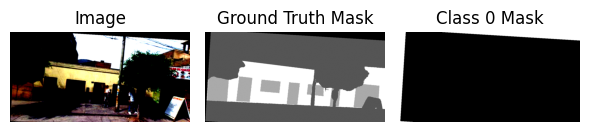

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.472244].


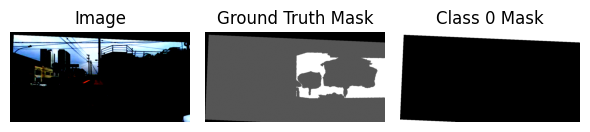

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


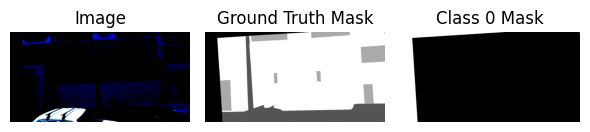

In [ ]:
def visualize_class_zero(dataset, num_images=3, class_id=0):
    indices = random.sample(range(len(dataset)), num_images)

    for idx in indices:
        image, mask = dataset[idx]

        class_zero_mask = (mask == class_id).numpy()

        fig, axs = plt.subplots(1, 3, figsize=(6, 3))
        axs[0].imshow(image.permute(1, 2, 0).numpy())
        axs[0].set_title("Image")
        axs[1].imshow(mask.numpy(), cmap='gray')
        axs[1].set_title("Ground Truth Mask")
        axs[2].imshow(class_zero_mask, cmap='gray')
        axs[2].set_title(f"Class {class_id} Mask")
        for ax in axs:
            ax.axis('off')
        plt.tight_layout()
        plt.show()

#Apply function
visualize_class_zero(train_dataset, num_images=3, class_id=0)

In [10]:
device = torch.device("cuda")

In [ ]:
def compute_metrics(preds, labels, num_classes, ignore_class=0):
    #Filter valid labels
    valid = labels != 255
    preds = preds[valid]
    labels = labels[valid]

    #Create confusion matrix
    cm = confusion_matrix(labels, preds, labels=list(range(num_classes)))

    #Exclude ignore_class
    cm = np.delete(cm, ignore_class, axis=0)  
    cm = np.delete(cm, ignore_class, axis=1) 

    TP = np.diag(cm)
    FP = cm.sum(axis=0) - TP
    FN = cm.sum(axis=1) - TP
    TN = cm.sum() - (TP + FP + FN)

    iou = TP / (TP + FP + FN + 1e-7)
    accuracy = (TP + TN) / (TP + TN + FP + FN + 1e-7)
    precision = TP / (TP + FP + 1e-7)
    recall = TP / (TP + FN + 1e-7)

    return {
        "mean_iou": np.mean(iou),
        "mean_accuracy": np.mean(accuracy),
        "mean_precision": np.mean(precision),
        "mean_recall": np.mean(recall),
        "iou": iou,
        "precision": precision,
        "recall": recall
    }

#### Define evaluation process

In [ ]:
#Evaluation
def evaluate(model, dataloader, criterion, device, epoch):
    model.eval()
    val_loss = 0.0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for i, (images, masks) in enumerate(dataloader):
            images, masks = images.to(device), masks.to(device)
            
            #Mixed precision inference
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, masks)

            val_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            all_preds.append(preds)
            all_labels.append(masks)

            if i == 0:
                input_img = images[0]
                pred_img = preds[0].unsqueeze(0).float() / (num_classes - 1)
                mask_img = masks[0].unsqueeze(0).float() / (num_classes - 1)

                writer.add_image("Input", input_img, epoch)
                writer.add_image("Prediction", pred_img, epoch)
                writer.add_image("Mask", mask_img, epoch)

    all_preds = torch.cat(all_preds).view(-1)
    all_labels = torch.cat(all_labels).view(-1)
    metrics = compute_metrics(all_preds.cpu().numpy(), all_labels.cpu().numpy(), num_classes, ignore_class=0)


    #IoU, precision and recall per class (all classes were reduced by 1 because of the ignore_class)
    idx_class_3 = 1  # Real class 2 (porosity) 
    idx_class_4 = 2  # Real class 3 (wall)  

    
    return val_loss / len(dataloader), metrics

In [ ]:
def compute_class_weights(masks_dir, num_classes, ignore_class=0):
    class_counts = np.zeros(num_classes, dtype=np.int64)

    for filename in os.listdir(masks_dir):
        mask_path = os.path.join(masks_dir, filename)
        mask = np.array(Image.open(mask_path), dtype=np.int64)

        for c in range(num_classes):
            if c == ignore_class:
                continue
            class_counts[c] += np.sum(mask == c)

    #Get weights by inverting the frequence of pixels of that class
    class_weights = 1.0 / (class_counts + 1e-6)

    #Add weight 0 to ignored class
    class_weights[ignore_class] = 0.0

    #Normalise
    class_weights = class_weights / class_weights.sum() * (num_classes - 1)

    return torch.tensor(class_weights, dtype=torch.float32)


#Apply
num_classes = 4
class_weights = compute_class_weights(ft_train_masks_dir, num_classes, ignore_class=0).to(device)
print("Class weights:", class_weights)

Class weights: tensor([0.0000, 0.5197, 1.8541, 0.6261], device='cuda:0')


### Fine-tune it with Self annotated images

#### Load fine-tuning dataset (Self annotated images)

In [ ]:
#Training
num_epochs = 100
patience = 10
best_val_loss = float('inf')
early_stop_counter = 0
num_classes=4

model = smp.DeepLabV3Plus(
    encoder_name="resnet101",         # Cambia a mobilenet_v2 o efficientnet-b0 si necesitas
    encoder_weights="imagenet",      # O None si no quieres preentrenamiento
    in_channels=3,                   # RGB
    classes=num_classes              # Tus 4 clases
)

model.load_state_dict(torch.load("../best_deeplabmodels/V1_only_cmp_.pth"))
model = model.to(device)

g = torch.Generator()
g.manual_seed(seed)

#Fine-tune only layer4 of encoder
for name, param in model.encoder.named_parameters():
    if "layer4" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

train_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,      
    drop_last=True,
    pin_memory=True,
    num_workers=0,
    generator=g      
)

val_loader = DataLoader(
    val_dataset,
    batch_size=4,
    shuffle=False,  
    drop_last=True,
    pin_memory=True,
    num_workers=0
)

#Optimizer and loss
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4) #lower learning rate for fine-tuning
criterion = nn.CrossEntropyLoss(weight=class_weights, ignore_index=0)

#Write stats with TensorBoard to see training in real time
writer = SummaryWriter(log_dir="../training_stats/V4_cmp_ft_decoder_")

# Initialize the scaler
scaler = GradScaler()

metrics_log = {
    "epoch": [],
    "train_loss": [],
    "val_loss": [],
    "mean_iou": [],
    "mean_accuracy": [],
    "mean_precision": [],
    "mean_recall": [],
    "epoch_time_sec": [],
    "learning_rate": []
}

for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    running_loss = 0.0

    for i, (images, masks) in enumerate(train_loader):
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()

        #Mixed precision
        with autocast():
            outputs = model(images)
            loss = criterion(outputs, masks)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    avg_val_loss, val_metrics = evaluate(model, val_loader, criterion, device, epoch)

    #Extract metrics by class
    iou_class_3 = val_metrics["iou"][1]
    iou_class_4 = val_metrics["iou"][2]
    precision_class_3 = val_metrics["precision"][1]
    precision_class_4 = val_metrics["precision"][2]
    recall_class_3 = val_metrics["recall"][1]
    recall_class_4 = val_metrics["recall"][2]

    #Add metrics to TensorBoard
    writer.add_scalar("Val/Class3_IoU", iou_class_3, epoch)
    writer.add_scalar("Val/Class4_IoU", iou_class_4, epoch)
    writer.add_scalar("Val/Class3_Precision", precision_class_3, epoch)
    writer.add_scalar("Val/Class4_Precision", precision_class_4, epoch)
    writer.add_scalar("Val/Class3_Recall", recall_class_3, epoch)
    writer.add_scalar("Val/Class4_Recall", recall_class_4, epoch)

    #Add to metrics_log for saving in CSV
    metrics_log.setdefault("iou_class_3", []).append(iou_class_3)
    metrics_log.setdefault("iou_class_4", []).append(iou_class_4)
    metrics_log.setdefault("precision_class_3", []).append(precision_class_3)
    metrics_log.setdefault("precision_class_4", []).append(precision_class_4)
    metrics_log.setdefault("recall_class_3", []).append(recall_class_3)
    metrics_log.setdefault("recall_class_4", []).append(recall_class_4)

    epoch_time = time.time() - start_time
    current_lr = optimizer.param_groups[0]["lr"]

    metrics_log["epoch"].append(epoch + 1)
    metrics_log["train_loss"].append(avg_train_loss)
    metrics_log["val_loss"].append(avg_val_loss)
    metrics_log["mean_iou"].append(val_metrics["mean_iou"])
    metrics_log["mean_accuracy"].append(val_metrics["mean_accuracy"])
    metrics_log["mean_precision"].append(val_metrics["mean_precision"])
    metrics_log["mean_recall"].append(val_metrics["mean_recall"])
    metrics_log["epoch_time_sec"].append(epoch_time)
    metrics_log["learning_rate"].append(current_lr)

    writer.add_scalars("Loss", {
        "Train": avg_train_loss,
        "Val": avg_val_loss
    }, epoch)
    writer.add_scalar("Val/Mean_IoU", val_metrics["mean_iou"], epoch)
    writer.add_scalar("Val/Mean_Accuracy", val_metrics["mean_accuracy"], epoch)
    writer.add_scalar("Val/Mean_Precision", val_metrics["mean_precision"], epoch)
    writer.add_scalar("Val/Mean_Recall", val_metrics["mean_recall"], epoch)

    print(f"+ Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Mean IoU: {val_metrics['mean_iou']:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), "../best_deeplabmodels/V5_cmp_ft_encoder_.pth")
        print("✔ Best model saved")
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping activated")
            break
    torch.cuda.empty_cache()

writer.close()
lengths = {k: len(v) for k, v in metrics_log.items()}
df = pd.DataFrame(metrics_log)
df.to_csv("../training_stats/V5_cmp_ft_encoder_/V5_cmp_ft_encoder_.csv", index=False)

print("Training finished.")

📘 Epoch 1/100 | Train Loss: 1.1089 | Val Loss: 0.6536 | Mean IoU: 0.5485
✅ Best model saved
📘 Epoch 2/100 | Train Loss: 0.7377 | Val Loss: 0.5589 | Mean IoU: 0.5754
✅ Best model saved
📘 Epoch 3/100 | Train Loss: 0.6306 | Val Loss: 0.5102 | Mean IoU: 0.5951
✅ Best model saved
📘 Epoch 4/100 | Train Loss: 0.5455 | Val Loss: 0.4910 | Mean IoU: 0.6029
✅ Best model saved
📘 Epoch 5/100 | Train Loss: 0.5357 | Val Loss: 0.4585 | Mean IoU: 0.6280
✅ Best model saved
📘 Epoch 6/100 | Train Loss: 0.5100 | Val Loss: 0.4661 | Mean IoU: 0.6206
📘 Epoch 7/100 | Train Loss: 0.4613 | Val Loss: 0.4596 | Mean IoU: 0.6244
📘 Epoch 8/100 | Train Loss: 0.4418 | Val Loss: 0.4515 | Mean IoU: 0.6352
✅ Best model saved
📘 Epoch 9/100 | Train Loss: 0.4222 | Val Loss: 0.4393 | Mean IoU: 0.6407
✅ Best model saved
📘 Epoch 10/100 | Train Loss: 0.3967 | Val Loss: 0.4606 | Mean IoU: 0.6305
📘 Epoch 11/100 | Train Loss: 0.3887 | Val Loss: 0.4258 | Mean IoU: 0.6515
✅ Best model saved
📘 Epoch 12/100 | Train Loss: 0.3739 | Val L